# L2RPN Neurips2020 Track2 - Multi mix

In [14]:
# Run this cell to generate navigation menu
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=5)

## 1) Track2 - The multi mix problem

### 1.1) IEEE Case 118 powergrid

L2RPN Neurips 2020 track2 takes place on a version of the IEEE 118 power grid.

Where all lines, substations, loads and generators are in fixed positions:


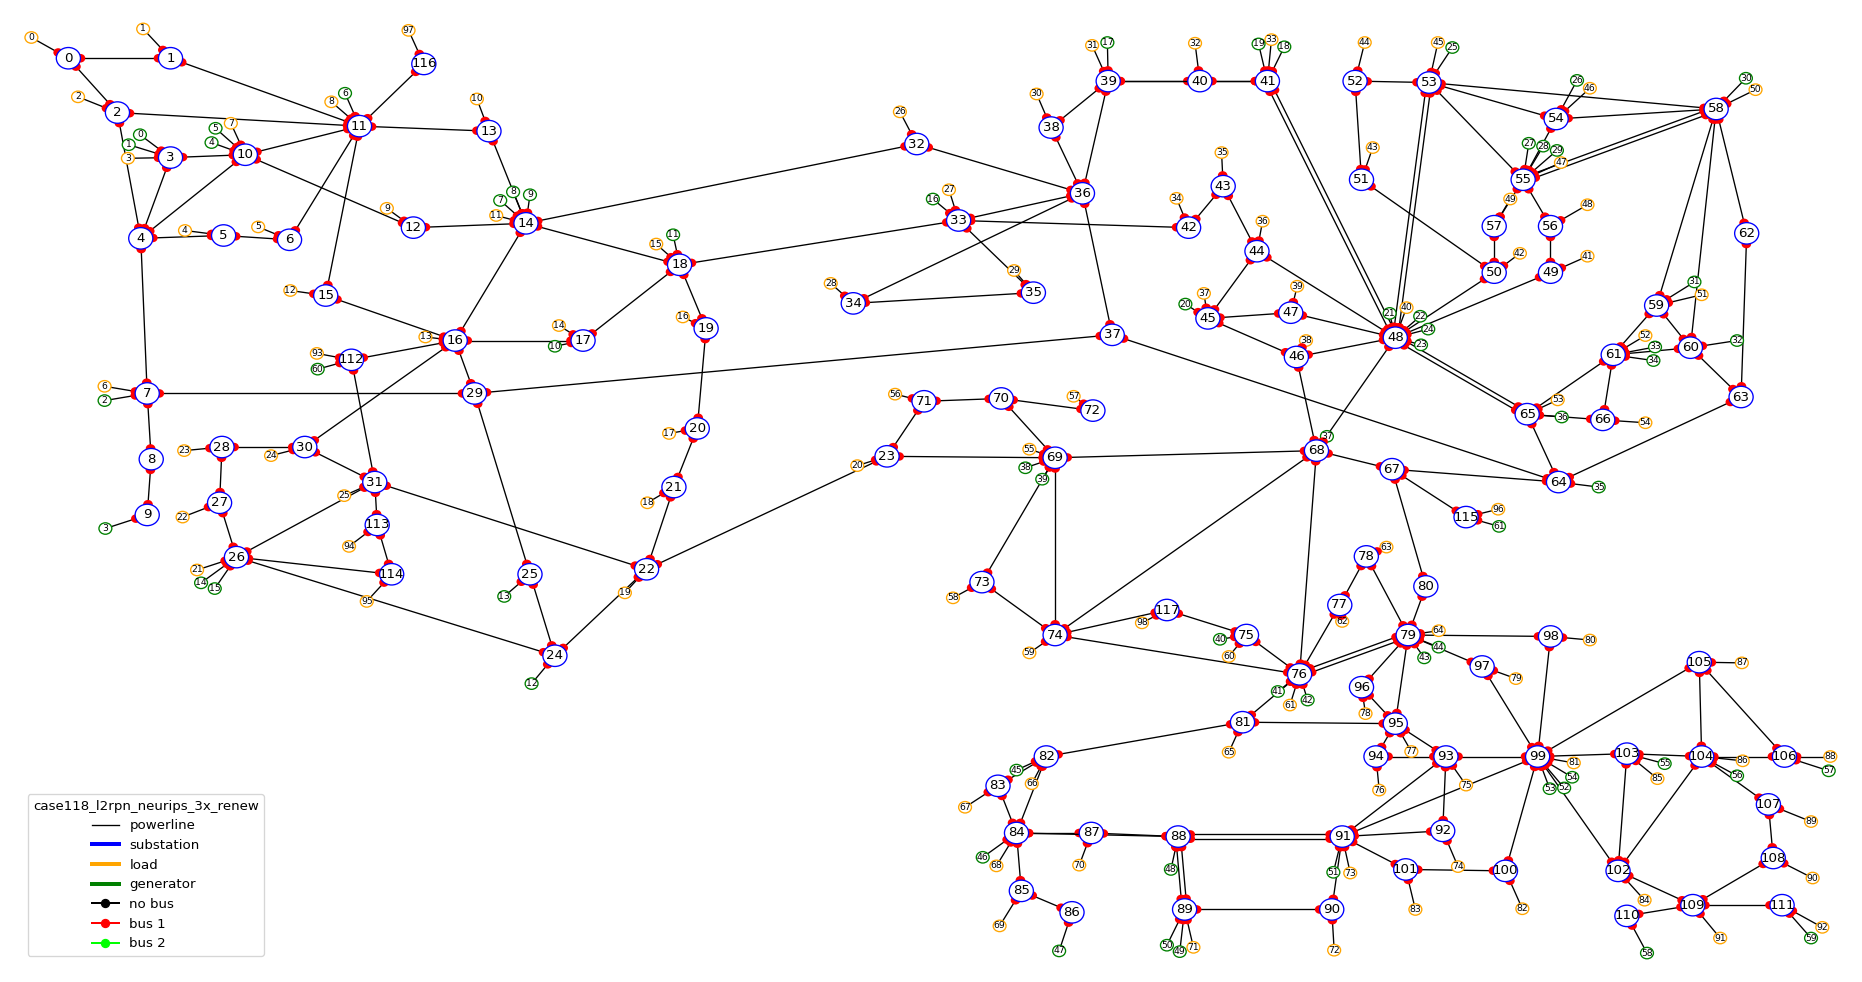

### 1.2) Increasing renewables share in the energy mix

As the grid is fixed geographically, the problem proposed in this track 2 wants participants to focus on **learning flexibilites** when the share of renewables energy production is increasing. We defined energy mixes in the range `[1.0;3.0]`, where:

 - `1.0` is a representation of today's (2020) energy mix: 
 
     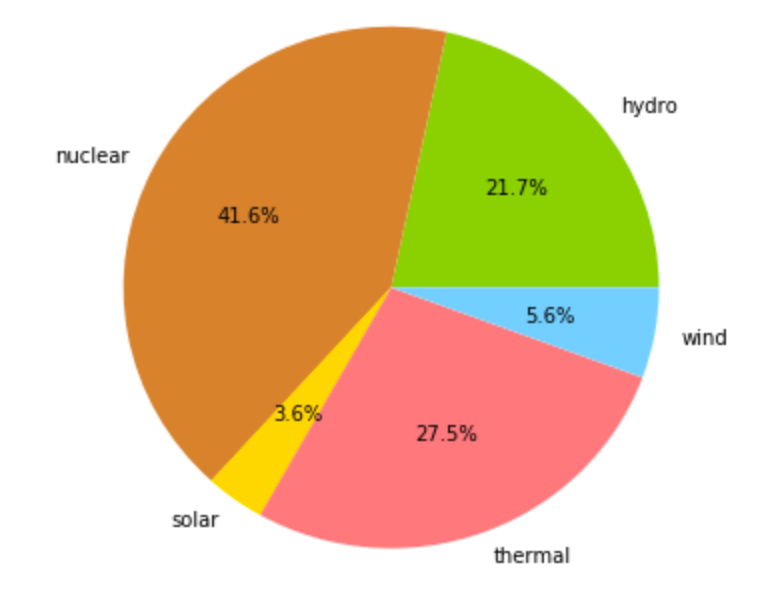
 
 
 - `3.0` is a projection in the future with three times more renewables production: 
       
     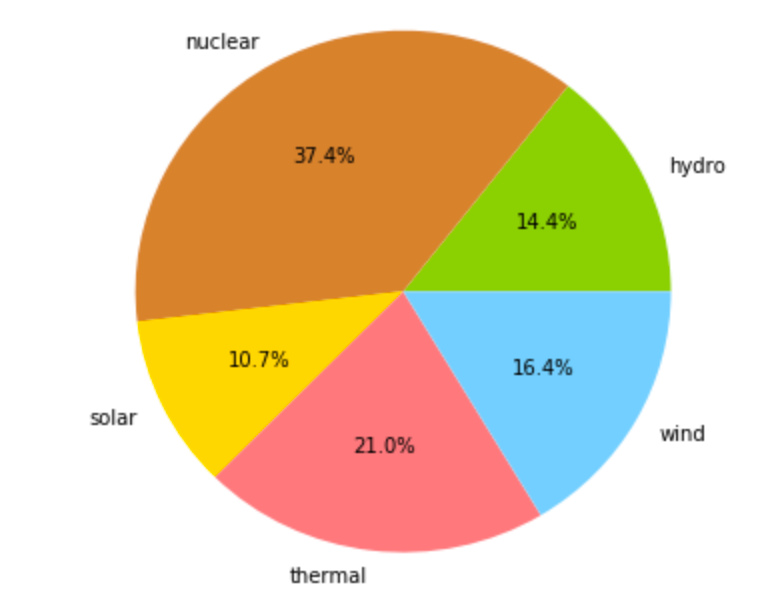
     

### 1.3) Goals

Your mission, if you choose to accept it, is to develop an agent able to operate the power grid regardless of the energy mix.

You will need to manage the power grid for all energy mixes in the range [1.0; 3.0] within the safety limits and at the lowest possible cost.

### 1.4) Competition phases

| Phase      |  Start     |  End       | Description      | Max submissions per day | Max submissions total |
|:-----------|:-----------|:-----------|:-----------------|:-------:|:--------:|
| warmup     | 08/07/2020 | 17/08/2020 |  The warmup phase is designed to let everyone experiment with the proposed problem, create and submit early agents. During warmup, participants may find bugs, unexpected behaviors and other errors in the track setup. In that case, the organizers are commited to assess, correct and update the competition software and datasets based on the community feedback.   | 20 | 1000
| validation | 18/08/2020 | 27/10/2020 |  The validation phase is the main competition phase. Participants are allowed to submit their code up to 20 times a day within the limit of 1,000 total submissions during the phase.  | 20 | 1000 |
| test       | 28/10/2020 | 29/10/2020 |  In the final phase, the **last** solution from the validation phase of each participant is tested on a new dataset and ranked by score. Winners will be announced after all submissions have been tested and verified. | 1 | 1 |

## 2) Datasets

### 2.1) Dataset Structure

The environment folder should contain the following files for N mixes:
```
|---l2rpn_neurips_2020_track2_...
    |--- mix1_name
        |--- config.py
        |--- grid.json
        |--- grid_layout.json
        |--- prods_chatac.csv
        |--- difficulty_levels.json
        |--- chronics
            |---Scenario_january_01
            .
            .
            .
            |---Scenario_december_XX
    |---mix2_name
    .
    .
    .
    |---mixN_name
```
**Notice** that for this competition, the grid, productions and loads are the same. **The only difference is the amount of renewables**


### 2.2) Training datasets

Two versions of the multimix training dataset are provided for this track:
 - `l2rpn_neurips_2020_track2_small`
 - `l2rpn_neurips_2020_track2_large`
 
Where the `small` dataset is a subset of the `large` dataset, with a similar distribution over the mixes and months. 

We recommend prototyping and getting familiar with the `small` dataset before working with the `large` dataset. 


---



| Dataset                           |  Size   |     Energy Mixes      | Number of months |
|:----------------------------------|:--------|:----------------------|:-----------------|
| l2rpn_neurips_2020_track2_small   | ~2Go    | [1.0,1.5,2.0,2.5,3.0] |  5x12x10 = 600   |
| l2rpn_neurips_2020_track2_large   | ~12Go   | [1.0,1.5,2.0,2.5,3.0] |  5x12x48 = 2880  |



### 2.2) Evaluation datasets

For evaluation and ranking on the Codalab platform, **hidden** datasets will be used, one for each phase:
 - `l2rpn_neurips_2020_track2_warmup`
 - `l2rpn_neurips_2020_track2_val`
 - `l2rpn_neurips_2020_track2_test`


These datasets are composed of 24 weekly scenarios from 2 unseen mixes in the range `[1.0;3.0]`, or 2x12 scenarios given 2 scenarios for each month of the year

**Note that evaluation datasets will NOT be made available during the competition and will only run on Codalab platform for evaluation**

## 3) Grid2Op and MultiMix datasets

### 3.1) Grid2Op framework

The framework used in this competition is Grid2Op. This open source framework, developped by RTE, is the simulation environment for the powergrid and the agents.

We won't go into the details here, but many ressources are available to help and explain how to use it:
 - [Getting started notebooks](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)
 - [Documentation](https://grid2op.readthedocs.io/en/latest/?badge=latest)
 - [Github repository](https://github.com/rte-france/Grid2Op)

### 3.2) Training environment

#### 3.2.1) Load training dataset

Using `grid2op.make` is the easiest way to load environments.

This method will download the dataset and store it in a cache the first time the dataset is used

In [2]:
import grid2op

# For this notebook we use a dummy test dataset
NOTEBOOK_DATASET = "l2rpn_neurips_2020_track2"
NOTEBOOK_TEST_FLAG = True
# But the track2 dataset is this one
TRACK2_DATASET = "l2rpn_neurips_2020_track2_small"
TRACK2_TEST_FLAG = False

multimix_env = grid2op.make(NOTEBOOK_DATASET, test=NOTEBOOK_TEST_FLAG)

/home/tezirg/Code/envdesign.marota/competition_codalab/venv_codalab/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:255: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


#### 3.2.2) Class MultiMixEnvironment

The environment for multimix datasets is a bit different from 'regular' grid2op environments (`grid2op.Environment.Environment`)

In fact, it is a container of multiple grid2op environments (`grid2op.Environment.MultiMixEnvironment`)

In [3]:
# Check the class name 
print ("Class : ", multimix_env.__class__.__name__)

# How many mixes in this multimix ?
print ("Number of mixes: ", len(multimix_env))

# What are the mixes in this multimix ? 
print ("Names of the mixes: ", list(multimix_env.keys()))

Class :  MultiMixEnvironment_l2rpn_neurips_2020_track2
Number of mixes:  2
Names of the mixes:  ['x1', 'x2.5']


#### 3.2.3) MultiMixEnvironment: usage & reset

The `MultiMixEnvironment` will forward any call to the current mix environment. And change mix when the `reset` method is called. 
This is designed so it can be used like a 'normal' environment, please refer to the `grid2op.Environment` [interface documentation](https://grid2op.readthedocs.io/en/latest/environment.html)

For example:

In [4]:
print ("Mix before reset: ", multimix_env.name)
# Take a do nothing action in mix 1
obs, reward, done, info = multimix_env.step(multimix_env.action_space({}))

multimix_env.reset()
print ("Mix after reset: ", multimix_env.name)
# Take a do nothing action in mix 2
obs, reward, done, info = multimix_env.step(multimix_env.action_space({}))

# Asking for a random mix on reset
multimix_env.reset(random=True)
print ("Mix after random reset: ", multimix_env.name)

Mix before reset:  x1
Mix after reset:  x2.5
Mix after random reset:  x2.5


For more control, a `dict` like interface is provided:

In [5]:
print ("Iterate on (key,value) like a dict")
for mix_name, mix_env in multimix_env.items():
    print (mix_name)
    print (type(mix_env))
    print("--")

Iterate on (key,value) like a dict
x1
<class 'grid2op.Space.GridObjects.Environment_x1'>
--
x2.5
<class 'grid2op.Space.GridObjects.Environment_x2.5'>
--


In [6]:
print("Iterate on keys like a dict")
for mix_name in multimix_env.keys():
    print (mix_name)
    print("--")
    

Iterate on keys like a dict
x1
--
x2.5
--


In [7]:
print("Iterate on values like a dict")
for mix_env in multimix_env.values():
    print (type(mix_env))
    print("--")
   

Iterate on values like a dict
<class 'grid2op.Space.GridObjects.Environment_x1'>
--
<class 'grid2op.Space.GridObjects.Environment_x2.5'>
--


In [8]:
print("Access by key like a dict [] ")
example_key = list(multimix_env.keys())[-1]
print ("Using key: ", example_key)
print (type(multimix_env[example_key]))

Access by key like a dict [] 
Using key:  x2.5
<class 'grid2op.Space.GridObjects.Environment_x2.5'>


#### 3.2.4) Training loops

Once we are familiar with the `MultiMixEnvironment` wrapper interface and controls decribed above, we can create training loops for agents.

Let's define some constants and a `DummyAgent` for this example:

In [9]:
import numpy as np
import grid2op
from grid2op.Agent import DoNothingAgent

class DummyAgent(DoNothingAgent):
    def __init__(self, action_space):
        super().__init__(action_space)

multimix_env = grid2op.make(NOTEBOOK_DATASET, test=NOTEBOOK_TEST_FLAG)
my_agent = DummyAgent(multimix_env.action_space)
NUM_EPISODES = 20
MAX_STEPS = 5

/home/tezirg/Code/envdesign.marota/competition_codalab/venv_codalab/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:255: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


##### 3.2.4.1) Sequential training loop

The most basic loop using the default behavior loops over ordered scenarios one mix after another: 

In [10]:
for i in range(NUM_EPISODES):
    multimix_env.reset()
    
    # Print some info on current episode
    mix_name = multimix_env.name
    chronic_name = multimix_env.chronics_handler.get_name()
    print ("Episode [{}] - Mix [{}] - Chronic [{}]".format(i, mix_name, chronic_name))
    
    done = False
    obs = multimix_env.current_obs
    reward = 0.0
    step = 0
    while done is False and step < MAX_STEPS:
        agent_action = my_agent.act(obs, reward, done)
        obs, reward, done , info = multimix_env.step(agent_action)
        step += 1


Episode [0] - Mix [x2.5] - Chronic [002]
Episode [1] - Mix [x1] - Chronic [002]
Episode [2] - Mix [x2.5] - Chronic [001]
Episode [3] - Mix [x1] - Chronic [001]
Episode [4] - Mix [x2.5] - Chronic [002]
Episode [5] - Mix [x1] - Chronic [002]
Episode [6] - Mix [x2.5] - Chronic [001]
Episode [7] - Mix [x1] - Chronic [001]
Episode [8] - Mix [x2.5] - Chronic [002]
Episode [9] - Mix [x1] - Chronic [002]
Episode [10] - Mix [x2.5] - Chronic [001]
Episode [11] - Mix [x1] - Chronic [001]
Episode [12] - Mix [x2.5] - Chronic [002]
Episode [13] - Mix [x1] - Chronic [002]
Episode [14] - Mix [x2.5] - Chronic [001]
Episode [15] - Mix [x1] - Chronic [001]
Episode [16] - Mix [x2.5] - Chronic [002]
Episode [17] - Mix [x1] - Chronic [002]
Episode [18] - Mix [x2.5] - Chronic [001]
Episode [19] - Mix [x1] - Chronic [001]


##### 3.2.4.2) Sequential per mix training loop

We can also iterate sequentialy over all chronics in each mix: 

In [11]:
i = 0
while i < NUM_EPISODES:
    for mix in multimix_env:
        # Get number of chronics in this mix
        n_chronics_mix = len(mix.chronics_handler.subpaths)
        # Adjust iterations to limit to NB_EPISODES
        if (i + n_chronics_mix) > NUM_EPISODES:
            n_chronics_mix = NUM_EPISODES - i
        
        # Iterate over this mix scenarios
        for c in range(n_chronics_mix):
            mix.reset()
        
            # Print some info on current episode
            mix_name = mix.name
            chronic_name = mix.chronics_handler.get_name()
            print ("Episode [{}] - Mix [{}] - Chronic [{}]".format(i, mix_name, chronic_name))

            done = False
            obs = mix.current_obs
            reward = 0.0
            step = 0
            while done is False and step < MAX_STEPS:
                agent_action = my_agent.act(obs, reward, done)
                obs, reward, done , info = mix.step(agent_action)
                step += 1
            i += 1

Episode [0] - Mix [x1] - Chronic [002]
Episode [1] - Mix [x1] - Chronic [001]
Episode [2] - Mix [x2.5] - Chronic [002]
Episode [3] - Mix [x2.5] - Chronic [001]
Episode [4] - Mix [x1] - Chronic [002]
Episode [5] - Mix [x1] - Chronic [001]
Episode [6] - Mix [x2.5] - Chronic [002]
Episode [7] - Mix [x2.5] - Chronic [001]
Episode [8] - Mix [x1] - Chronic [002]
Episode [9] - Mix [x1] - Chronic [001]
Episode [10] - Mix [x2.5] - Chronic [002]
Episode [11] - Mix [x2.5] - Chronic [001]
Episode [12] - Mix [x1] - Chronic [002]
Episode [13] - Mix [x1] - Chronic [001]
Episode [14] - Mix [x2.5] - Chronic [002]
Episode [15] - Mix [x2.5] - Chronic [001]
Episode [16] - Mix [x1] - Chronic [002]
Episode [17] - Mix [x1] - Chronic [001]
Episode [18] - Mix [x2.5] - Chronic [002]
Episode [19] - Mix [x2.5] - Chronic [001]


##### 3.2.4.3) Random training loop

We can also create a random scenario & mix loop: 

In [12]:
# Shuffle scenarios in all mixes
for mix in multimix_env:
    # Using numpy to shuffle list
    def shuff(x):
        lx = len(x)
        s = np.random.choice(lx, size=lx, replace=False)
        return x[s]

    # Call 'regular' environment scenario shuffle
    mix.chronics_handler.shuffle(shuffler=shuff)

# Enter training loop
for i in range(NUM_EPISODES):
    # Pick a random mix on reset
    multimix_env.reset(random=True)
    
    # Print some info on current episode
    mix_name = multimix_env.name
    chronic_name = multimix_env.chronics_handler.get_name()
    print ("Episode [{}] - Mix [{}] - Chronic [{}]".format(i, mix_name, chronic_name))
    
    done = False
    obs = multimix_env.current_obs
    reward = 0.0
    step = 0
    while done is False and step < MAX_STEPS:
        agent_action = my_agent.act(obs, reward, done)
        obs, reward, done , info = multimix_env.step(agent_action)
        step += 1

Episode [0] - Mix [x1] - Chronic [002]
Episode [1] - Mix [x2.5] - Chronic [002]
Episode [2] - Mix [x1] - Chronic [001]
Episode [3] - Mix [x2.5] - Chronic [001]
Episode [4] - Mix [x2.5] - Chronic [002]
Episode [5] - Mix [x1] - Chronic [002]
Episode [6] - Mix [x2.5] - Chronic [001]
Episode [7] - Mix [x1] - Chronic [001]
Episode [8] - Mix [x2.5] - Chronic [002]
Episode [9] - Mix [x2.5] - Chronic [001]
Episode [10] - Mix [x1] - Chronic [002]
Episode [11] - Mix [x1] - Chronic [001]
Episode [12] - Mix [x1] - Chronic [002]
Episode [13] - Mix [x2.5] - Chronic [002]
Episode [14] - Mix [x1] - Chronic [001]
Episode [15] - Mix [x1] - Chronic [002]
Episode [16] - Mix [x2.5] - Chronic [001]
Episode [17] - Mix [x2.5] - Chronic [002]
Episode [18] - Mix [x1] - Chronic [001]
Episode [19] - Mix [x2.5] - Chronic [001]


### 3.3) Evalutation environment

In an evaluation mode, to make use of the [`grid2op.Runner`](https://grid2op.readthedocs.io/en/latest/runner.html): 

The `MultiMixEnvironment` class is iterable and each mix can be given to the runner for sequentially evalutating an agent on all the mixes.

In [13]:
import os
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent

logs_path = "/tmp/track2nb/"
nb_episode = 2
max_steps = 10

multimix_env = grid2op.make(NOTEBOOK_DATASET, test=NOTEBOOK_TEST_FLAG)

# Iterate over each mix in the dataset
for mix in multimix_env:
        # Build runner
        runner_params = mix.get_params_for_runner()
        runner = Runner(**runner_params,
                        agentClass=DoNothingAgent,
                        agentInstance=None)
        # Run
        mix_logs_path = os.path.join(logs_path, mix.name)
        os.makedirs(mix_logs_path, exist_ok=True)
        res = runner.run(path_save=mix_logs_path,
                         nb_episode=nb_episode,
                         nb_process=1,
                         max_iter=max_steps,
                         pbar=False)

        # Print results for NB_EPISODE scenarios in ONE mix
        for chron_id, chron_name, cum_reward, nb_tstep, max_ts in res:
                msg_tmp = "Eval: {} {}".format(mix.name, chron_name)
                msg_tmp += "\tsteps: {:.0f}/{:.0f}".format(nb_tstep, max_ts)
                print(msg_tmp)

/home/tezirg/Code/envdesign.marota/competition_codalab/venv_codalab/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:255: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Eval: x1 001	steps: 10/10
Eval: x1 002	steps: 10/10
Eval: x2.5 001	steps: 10/10
Eval: x2.5 002	steps: 10/10
